<a href="https://colab.research.google.com/github/nericovich/project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект для задачи Яндекс Лицея "Анализ экологических проблем"

### На заводе по производству полезного полимера ООО “Synthesising the future“ обратились за помощью в исследовании зависимостей вредных выбросов от производственных показателей. Требуется повести анализ данных и построить выводы о том, какой этап имеет высокий риск создать повышенное содержания вредного газа.


## Импорты

In [1215]:
import pandas as pd
import seaborn as sns
from scipy.stats import mannwhitneyu, ttest_ind, shapiro
import numpy as np
from statistics import mode
from matplotlib.colors import LinearSegmentedColormap

In [1216]:
df = pd.read_csv('data.csv', sep=',', decimal='.', skipinitialspace=True)

## Main


### Обработка

In [1217]:
#Приведём все колонки к нормальному виду

df.columns = df.columns.str.lower().str.replace(' ', '_')

#нас не интересует те строчки, где отсутсвует целевая
df = df.dropna(subset=['stage_4_output_danger_gas'])
df = df.reset_index(drop=True)


In [1218]:
df.shape

(934, 24)

In [1219]:
df.dtypes

datetime                                 object
stage_1_output_konv_avd                 float64
stage_2_input_water_sum                 float64
stage_2_output_bottom_pressure          float64
stage_2_output_bottom_temp              float64
stage_2_output_bottom_temp_hum_steam    float64
stage_2_output_bottom_vacuum            float64
stage_2_output_top_pressure             float64
stage_2_output_top_pressure_at_end      float64
stage_2_output_top_temp                 float64
stage_2_output_top_vacuum               float64
stage_3_input_pressure                  float64
stage_3_input_soft_water                float64
stage_3_input_steam                     float64
stage_3_output_temp_hum_steam           float64
stage_3_output_temp_top                 float64
stage_4_input_overheated_steam          float64
stage_4_input_polymer                   float64
stage_4_input_steam                     float64
stage_4_input_water                     float64
stage_4_output_danger_gas               

#### Пропуски

In [1220]:
df.isna().sum()

datetime                                 0
stage_1_output_konv_avd                 12
stage_2_input_water_sum                 15
stage_2_output_bottom_pressure          18
stage_2_output_bottom_temp               8
stage_2_output_bottom_temp_hum_steam     4
stage_2_output_bottom_vacuum            24
stage_2_output_top_pressure              4
stage_2_output_top_pressure_at_end       1
stage_2_output_top_temp                  9
stage_2_output_top_vacuum               10
stage_3_input_pressure                  17
stage_3_input_soft_water                10
stage_3_input_steam                      1
stage_3_output_temp_hum_steam            2
stage_3_output_temp_top                 14
stage_4_input_overheated_steam           2
stage_4_input_polymer                   10
stage_4_input_steam                     26
stage_4_input_water                     21
stage_4_output_danger_gas                0
stage_4_output_dry_residue_avg           0
stage_4_output_product                   0
work_shift 

Надо что-то сделать со всеми, кроме stage_4_output_danger_gas

In [1221]:
df[df['work_shift'].isna()]

,datetime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift


Пропуски везде - можно удалить

In [1222]:
print(df.shape)
df = df.dropna(subset=['work_shift'])
#Смена отсутсвует только в тех случаях, где все данные отсутвуют, уже нет смысла
print(df.shape)
df['work_shift'].value_counts()

(934, 24)
(934, 24)


work_shift
1.0    475
2.0    459
Name: count, dtype: int64

Проверим stage_4_output_product и stage_4_output_dry_residue_avg у них тоже было по 160 пропусков

In [1223]:
print(df['stage_4_output_product'].isna().sum())
df['stage_4_output_dry_residue_avg'].isna().sum()

0


0

In [1224]:
print(df['stage_4_input_water'].isna().sum())
df[df['stage_4_input_water'].isna()]

21


,datetime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
11,2021-02-01 16:00:00,69.33,122.41,470.79,81.63,93.33,46.68,414.94,211.51,99.18,...,110.37,44.59,156.63,11.18,7.74,NaN,0.24,22.88,37.22,2.0
118,2021-03-19 01:00:00,68.43,117.38,446.81,77.15,123.15,53.06,408.25,289.38,99.47,...,111.18,38.82,154.56,21.16,4.98,NaN,0.11,22.58,65.90,1.0
130,2021-03-24 08:00:00,71.83,80.05,313.33,74.63,104.88,50.06,397.21,282.51,94.63,...,109.43,37.62,155.51,18.42,3.99,NaN,0.12,21.88,66.30,2.0
214,2021-08-07 08:00:00,72.63,122.90,496.73,80.26,89.15,55.96,388.11,292.56,95.85,...,111.65,48.36,153.43,20.51,5.98,NaN,0.07,21.28,59.55,2.0
218,2021-09-09 13:00:00,68.63,116.46,359.21,78.63,102.68,57.38,437.97,266.50,96.20,...,109.95,46.55,153.41,21.28,5.49,NaN,0.11,21.78,69.33,2.0
264,2021-11-28 17:00:00,71.63,75.03,387.27,80.91,117.58,65.51,433.09,304.55,97.63,...,107.75,46.46,153.41,20.49,6.08,NaN,0.13,22.38,54.18,2.0
346,2021-12-21 09:00:00,70.73,61.20,463.05,80.48,100.86,60.80,461.21,299.41,98.91,...,111.40,43.68,151.61,20.54,6.42,NaN,0.19,23.58,50.66,2.0
446,2022-02-26 20:00:00,67.33,100.65,475.91,79.04,97.91,54.50,420.48,249.06,94.45,...,112.72,43.21,153.56,23.49,6.36,NaN,0.13,24.68,42.26,1.0
473,2022-03-12 21:00:00,72.93,69.95,340.52,77.52,94.79,59.06,429.08,291.79,95.69,...,111.04,41.30,153.73,18.76,4.69,NaN,0.20,22.78,45.26,2.0
483,2022-03-17 21:00:00,74.83,69.46,346.06,78.30,87.41,59.53,375.73,567.82,96.17,...,109.11,41.26,153.57,18.45,5.47,NaN,0.20,24.48,33.74,1.0


Вероятно, ошибки или сбои, тк воду точно подавали

302.10960569550934
285.56


<Axes: xlabel='stage_4_input_water', ylabel='Count'>

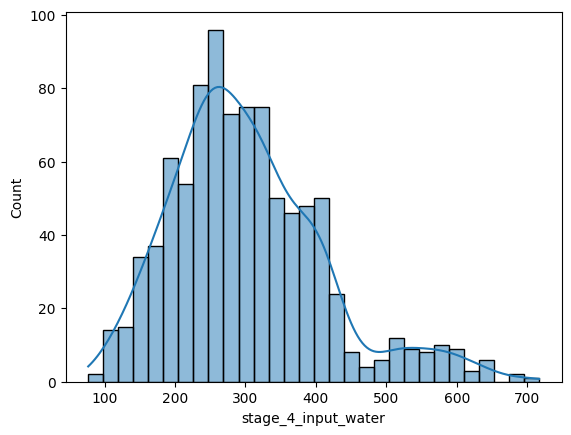

In [1225]:
print(df['stage_4_input_water'].mean())
print(df['stage_4_input_water'].median())
sns.histplot(df['stage_4_input_water'], kde=True, bins=30)

Распределение назвать нормальным - трудно, но все же можно заполнить медианой

In [1226]:
df['stage_4_input_water'] = df['stage_4_input_water'].fillna(df['stage_4_input_water'].median())
df['stage_4_input_water'].isna().sum()


0

stage_4_input_steam

In [1227]:
df[df['stage_4_input_steam'].isna()]

,datetime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
6,2021-01-31 00:00:00,74.63,114.53,478.53,81.46,97.90,58.06,450.41,289.65,98.35,...,NaN,47.05,156.51,26.05,NaN,449.78,0.18,22.88,55.43,1.0
16,2021-02-02 12:00:00,70.63,119.43,464.96,78.59,95.27,49.33,399.71,248.77,96.06,...,108.90,46.90,156.67,21.31,NaN,405.25,0.19,22.28,55.65,1.0
156,2021-04-02 09:00:00,68.43,83.85,347.16,76.70,103.90,55.19,425.15,308.99,96.06,...,108.82,47.18,154.53,17.66,NaN,354.98,0.09,22.48,59.06,2.0
306,2021-12-10 09:00:00,71.43,52.40,344.57,77.28,104.90,55.37,423.10,258.35,96.44,...,111.11,45.84,153.24,20.85,NaN,236.03,0.14,23.18,47.41,2.0
342,2021-12-20 21:00:00,69.73,67.44,475.73,82.44,95.95,68.06,486.30,337.55,97.57,...,111.48,43.97,151.30,22.18,NaN,265.27,0.19,23.58,52.79,1.0
362,2021-12-25 20:00:00,66.03,55.07,466.80,80.61,90.65,58.86,460.53,293.69,98.23,...,114.68,47.92,152.16,20.77,NaN,298.62,0.19,22.08,47.27,2.0
374,2021-12-29 11:00:00,72.63,59.55,463.77,80.88,89.01,64.38,482.70,324.79,96.59,...,113.77,46.59,151.89,20.41,NaN,263.02,0.16,21.18,46.09,2.0
411,2022-02-08 12:00:00,72.33,68.83,349.81,77.63,112.84,55.20,441.60,259.24,95.67,...,109.10,42.08,152.97,21.39,NaN,227.23,0.13,23.18,47.03,2.0
475,2022-03-13 21:00:00,69.83,74.27,343.14,77.77,93.00,58.82,470.47,286.67,95.68,...,111.30,41.24,153.38,19.40,NaN,252.86,0.19,22.68,38.48,1.0
481,2022-03-16 21:00:00,72.83,66.16,284.52,71.76,94.30,44.54,375.61,214.19,95.21,...,108.53,42.22,153.11,18.72,NaN,194.83,0.20,24.08,38.62,2.0


5.340594713656388
5.305


<Axes: xlabel='stage_4_input_steam', ylabel='Count'>

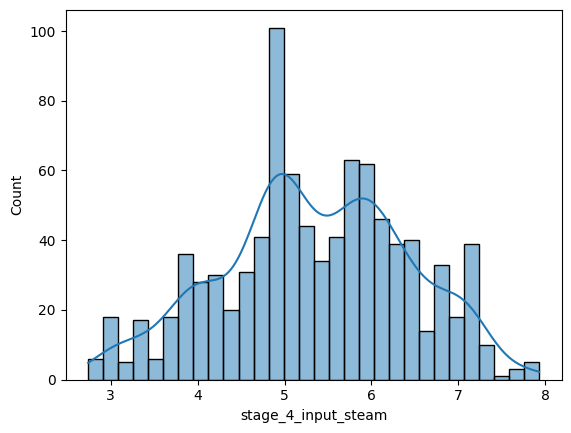

In [1228]:
print(df['stage_4_input_steam'].mean())
print(df['stage_4_input_steam'].median())
sns.histplot(df['stage_4_input_steam'], kde=True, bins=30)

In [1229]:
df[['stage_4_input_steam', 'stage_4_output_danger_gas']].corr(method='spearman')


,stage_4_input_steam,stage_4_output_danger_gas
stage_4_input_steam,1.000000,0.215835
stage_4_output_danger_gas,0.215835,1.000000


<Axes: xlabel='stage_4_input_steam', ylabel='stage_4_output_danger_gas'>

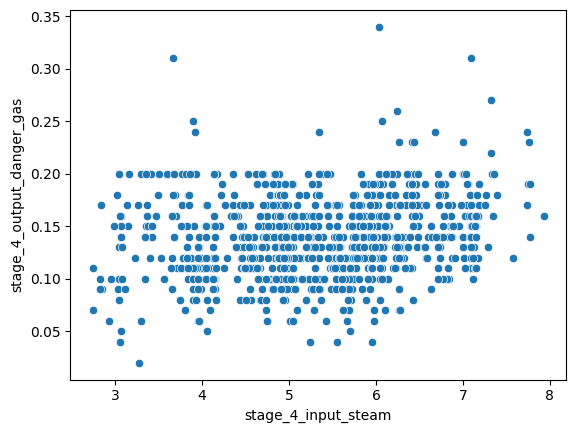

In [1230]:
sns.scatterplot(x='stage_4_input_steam', y='stage_4_output_danger_gas', data=df)


Заполню медианой пожалуй)))

Распределение признака является бимодальным, что может указывать на наличие двух различных подгрупп в данных. Несмотря на это, ранговая корреляция Спирмена между признаками составляет 0.22, что говорит о слабой положительной зависимости.


In [1231]:
df['stage_4_input_steam'] = df['stage_4_input_steam'].fillna(df['stage_4_input_steam'].median())
df['stage_4_input_steam'].isna().sum()

0

stage_4_input_polymer

In [1232]:
df[df['stage_4_input_polymer'].isna()]

,datetime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
13,2021-02-01 21:00:00,65.73,121.04,475.97,82.12,94.90,56.82,465.26,284.29,98.40,...,109.76,46.34,156.56,NaN,7.93,436.07,0.16,22.88,64.21,2.0
76,2021-02-23 12:00:00,71.33,113.15,453.23,79.74,92.49,53.57,473.38,280.13,97.22,...,109.08,39.83,156.74,NaN,5.67,348.85,0.12,23.48,43.81,1.0
122,2021-03-20 09:00:00,71.63,103.46,454.63,77.83,106.91,57.97,413.87,316.19,95.67,...,108.81,39.93,154.99,NaN,4.13,185.02,0.10,23.08,53.98,2.0
245,2021-11-23 13:00:00,72.43,77.73,342.22,77.89,90.38,56.18,369.12,244.12,96.09,...,108.11,43.94,152.55,NaN,6.73,385.71,0.14,22.48,60.55,2.0
293,2021-12-05 21:00:00,75.73,70.03,380.75,NaN,106.88,63.35,453.80,301.37,95.42,...,108.48,46.76,153.07,NaN,5.55,337.12,0.09,22.68,50.09,2.0
358,2021-12-24 12:00:00,73.83,42.65,458.83,81.27,102.51,61.83,477.07,305.12,99.66,...,113.89,45.30,151.83,NaN,6.52,300.69,0.17,23.08,48.90,1.0
377,2021-12-30 08:00:00,70.63,56.15,462.93,77.96,88.23,52.87,441.72,265.67,95.12,...,112.58,46.46,151.31,NaN,5.99,286.43,0.19,22.28,46.58,2.0
386,2022-01-19 08:00:00,74.33,81.28,474.36,79.97,90.10,54.62,519.98,277.69,93.17,...,121.71,40.75,153.48,NaN,5.99,351.15,0.16,23.98,55.09,2.0
652,2022-07-01 08:00:00,69.33,46.20,367.48,78.59,88.21,59.79,549.02,312.44,94.41,...,107.67,NaN,152.18,NaN,2.95,76.77,0.10,21.88,47.35,2.0
691,2022-07-22 12:00:00,65.33,105.12,405.75,82.25,96.59,52.51,488.20,201.93,92.56,...,109.06,38.76,151.65,NaN,5.68,421.67,0.09,20.68,56.31,2.0


20.090119047619044
20.475


<Axes: xlabel='stage_4_input_polymer', ylabel='Count'>

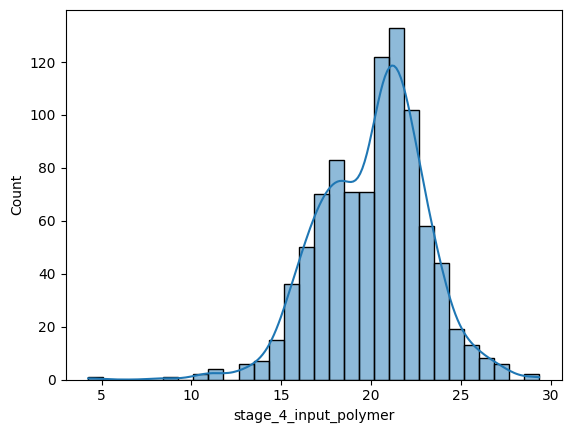

In [1233]:
print(df['stage_4_input_polymer'].mean())
print(df['stage_4_input_polymer'].median())
sns.histplot(df['stage_4_input_polymer'], kde=True, bins=30)

Похоже на нормальное, можно средним

In [1234]:
df['stage_4_input_polymer'] = df['stage_4_input_polymer'].fillna(df['stage_4_input_polymer'].mean())
df['stage_4_input_polymer'].isna().sum()

0

stage_4_input_overheated_steam подача перегретого пара, в м3

In [1235]:
df[df['stage_4_input_overheated_steam'].isna()]

,datetime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
272,2021-11-30 14:00:00,73.63,88.81,331.36,76.15,110.18,51.13,392.81,220.80,94.32,...,107.89,46.48,NaN,21.14,6.12,297.58,0.15,23.68,46.61,1.0
464,2022-03-06 09:00:00,74.93,113.09,342.37,76.68,94.44,56.32,392.39,258.79,94.85,...,119.47,41.19,NaN,21.23,6.19,308.43,0.20,24.28,31.59,1.0


153.30983905579401
153.165


<Axes: xlabel='stage_4_input_overheated_steam', ylabel='Count'>

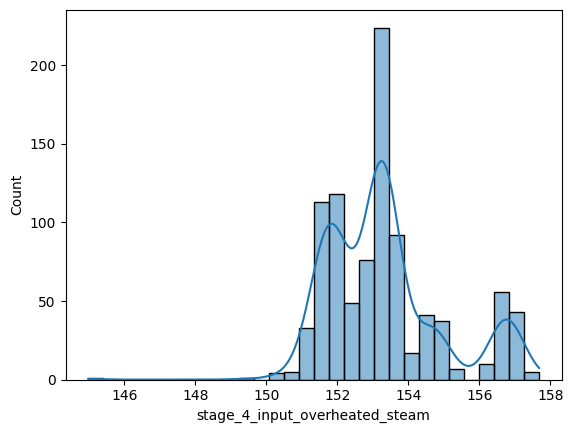

In [1236]:
print(df['stage_4_input_overheated_steam'].mean())
print(df['stage_4_input_overheated_steam'].median())
sns.histplot(df['stage_4_input_overheated_steam'], kde=True, bins=30)

Есть какая- то анамалия, но в целом норм....

In [1237]:
df['stage_4_input_overheated_steam'] = df['stage_4_input_overheated_steam'].fillna(df['stage_4_input_overheated_steam'].mean())
df['stage_4_input_overheated_steam'].isna().sum()

0

### Распределние

<Axes: xlabel='stage_1_output_konv_avd', ylabel='Density'>

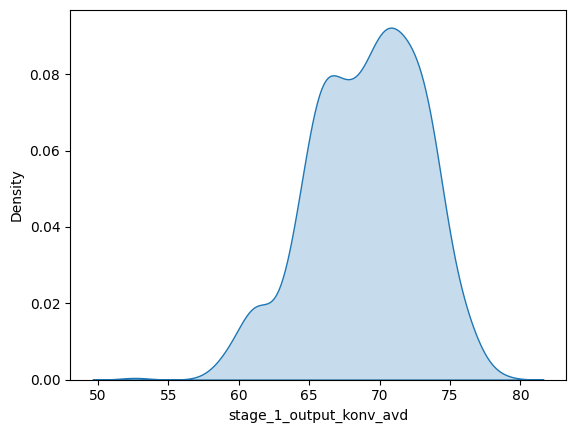

In [1238]:
sns.kdeplot(data=df, x='stage_1_output_konv_avd', fill=True)

<Axes: xlabel='stage_2_input_water_sum', ylabel='Density'>

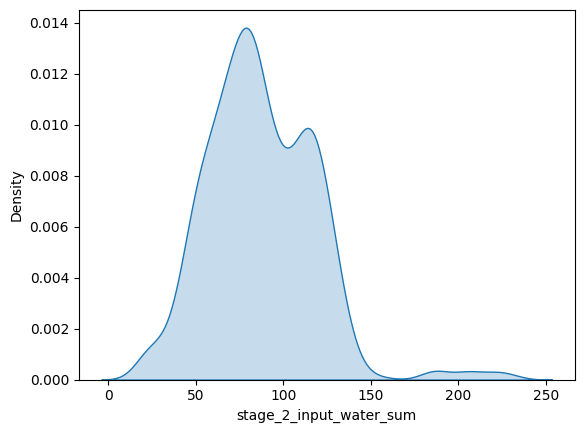

In [1239]:
sns.kdeplot(data=df, x='stage_2_input_water_sum', fill=True)

<Axes: xlabel='stage_2_output_bottom_pressure', ylabel='Density'>

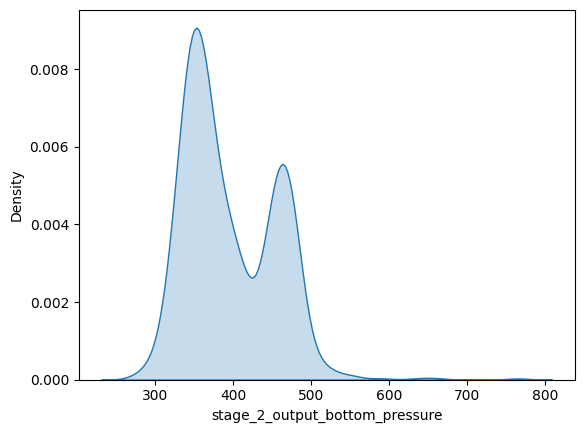

In [1240]:
sns.kdeplot(data=df, x='stage_2_output_bottom_pressure', fill=True)

<Axes: xlabel='stage_2_output_bottom_temp', ylabel='Density'>

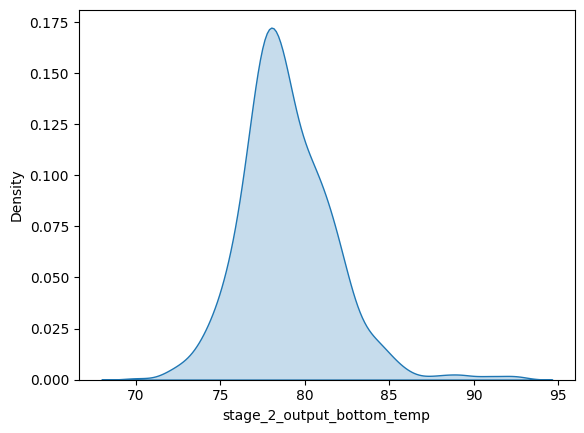

In [1241]:
sns.kdeplot(data=df, x='stage_2_output_bottom_temp', fill=True)

<Axes: xlabel='stage_2_output_top_pressure', ylabel='Density'>

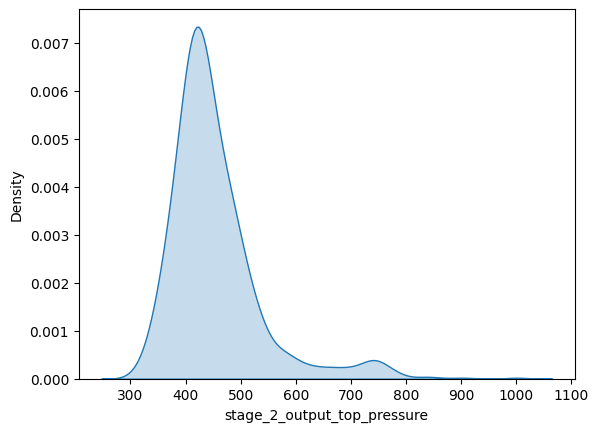

In [1242]:
sns.kdeplot(data=df, x='stage_2_output_top_pressure', fill=True)

<Axes: xlabel='stage_2_output_top_pressure_at_end', ylabel='Density'>

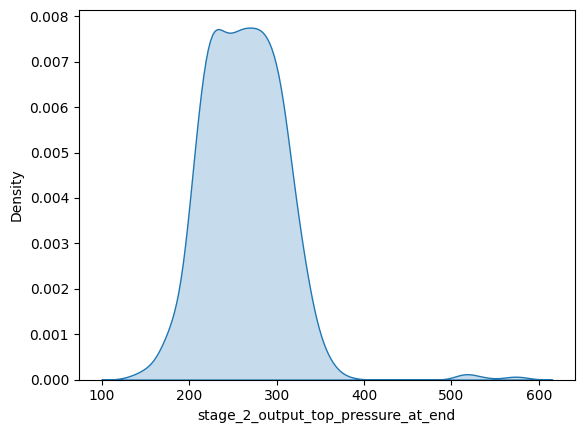

In [1243]:
sns.kdeplot(data=df, x='stage_2_output_top_pressure_at_end', fill=True)

<Axes: xlabel='stage_3_input_pressure', ylabel='Density'>

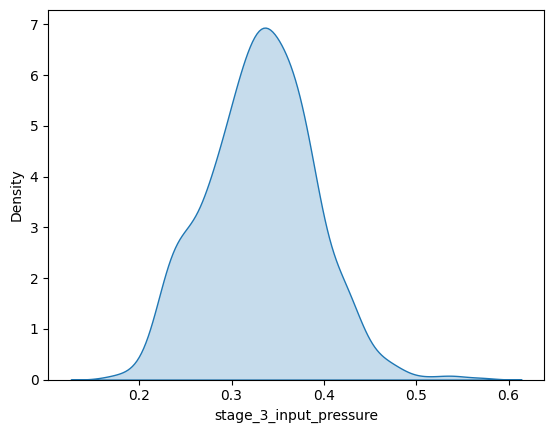

In [1244]:
sns.kdeplot(data=df, x='stage_3_input_pressure', fill=True)

<Axes: xlabel='stage_3_output_temp_hum_steam', ylabel='Density'>

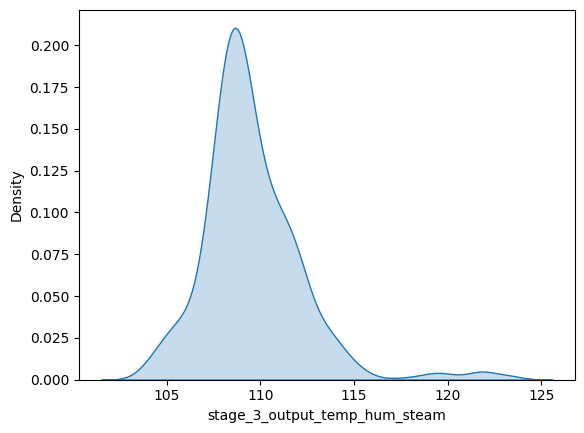

In [1245]:
sns.kdeplot(data=df, x='stage_3_output_temp_hum_steam', fill=True)

<Axes: xlabel='stage_3_output_temp_top', ylabel='Density'>

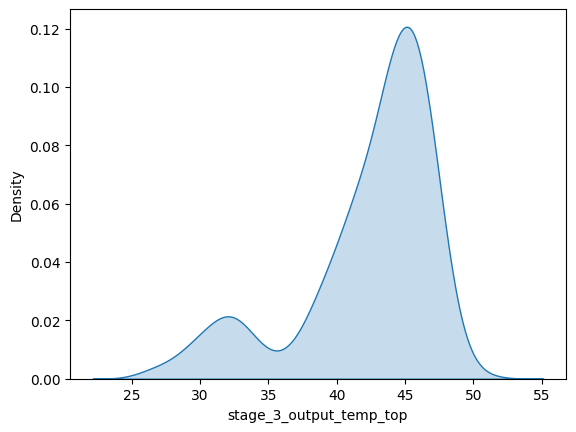

In [1246]:
sns.kdeplot(data=df, x='stage_3_output_temp_top', fill=True)

<Axes: xlabel='stage_4_input_overheated_steam', ylabel='Density'>

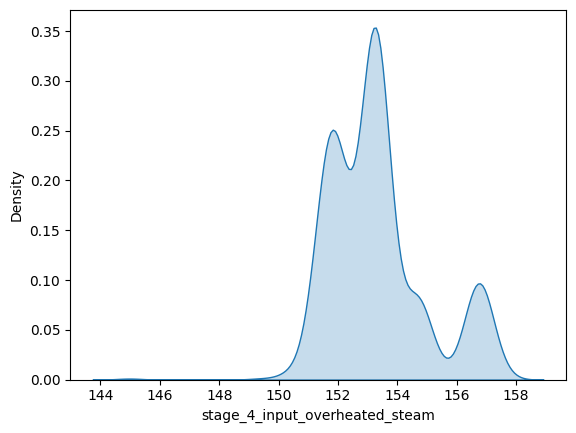

In [1247]:
sns.kdeplot(data=df, x='stage_4_input_overheated_steam', fill=True)

<Axes: xlabel='stage_4_output_danger_gas', ylabel='Density'>

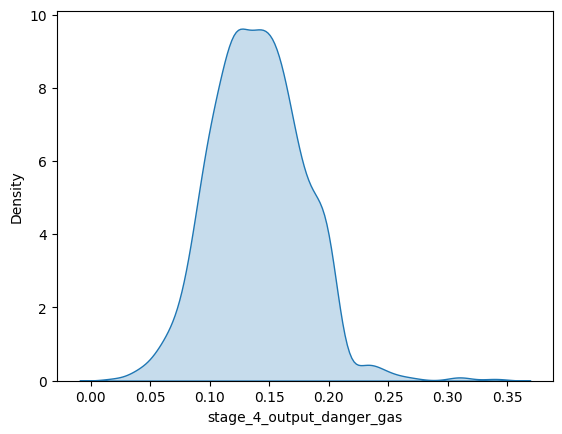

In [1248]:
sns.kdeplot(data=df, x='stage_4_output_danger_gas', fill=True)

In [1249]:

#Этой штукой я искал выбрался. Да не очень правильно, но ладно
print(df.shape)
for i in df.columns[1:]:
    curr_df = df[i].describe()
    H = curr_df.iloc[6] - curr_df.iloc[4]
    no_upper_light = curr_df.iloc[4] + H * 3
    no_lower_light = curr_df.iloc[6] - H * 3

    no_upper_hard = curr_df.iloc[4] + H * 6
    no_lower_hard = curr_df.iloc[6] - H * 6
    len_i = len(i)
    res_1 = df[((df[i] >= no_upper_hard) | (df[i] <= no_lower_hard))][i]
    if len(res_1) != 0:
        print(f'{i}{(40 - len_i) * " "}{len(res_1)} СУПЕР ВЫБРОС')
    
    res_2 = df[(df[i] >= no_upper_light) | (df[i] <= no_lower_light)][i]
    if len(res_2) != 0: 
        print(f'{i}{(40 - len_i) * " "}{len(res_2)} СЛАБЫЙ ВЫБРОС')
    print(' ')
    #без газа с выбросами - те данные которые мы в праве дропнуть(в теории) 
    #после того, как определим кол во строк с выбросами БЕЗ danger gas. Попробуем удалим
    #Пересмотреть варианты заполнения при ненормальном распределении...
    #Обучим несколько регрессионок. Условно: с выбросами, без выбросами...

(934, 24)
stage_1_output_konv_avd                 1 СЛАБЫЙ ВЫБРОС
 
stage_2_input_water_sum                 11 СЛАБЫЙ ВЫБРОС
 
stage_2_output_bottom_pressure          2 СЛАБЫЙ ВЫБРОС
 
stage_2_output_bottom_temp              12 СЛАБЫЙ ВЫБРОС
 
 
stage_2_output_bottom_vacuum            1 СУПЕР ВЫБРОС
stage_2_output_bottom_vacuum            22 СЛАБЫЙ ВЫБРОС
 
stage_2_output_top_pressure             2 СУПЕР ВЫБРОС
stage_2_output_top_pressure             46 СЛАБЫЙ ВЫБРОС
 
stage_2_output_top_pressure_at_end      6 СЛАБЫЙ ВЫБРОС
 
stage_2_output_top_temp                 57 СЛАБЫЙ ВЫБРОС
 
 
stage_3_input_pressure                  3 СЛАБЫЙ ВЫБРОС
 
stage_3_input_soft_water                3 СЛАБЫЙ ВЫБРОС
 
 
stage_3_output_temp_hum_steam           21 СЛАБЫЙ ВЫБРОС
 
stage_3_output_temp_top                 34 СЛАБЫЙ ВЫБРОС
 
stage_4_input_overheated_steam          13 СЛАБЫЙ ВЫБРОС
 
stage_4_input_polymer                   2 СЛАБЫЙ ВЫБРОС
 
 
stage_4_input_water                     12 СЛАБЫЙ ВЫ

In [1250]:
#Тыкаюсь с выбросами

fqw = ['stage_2_input_water_sum', 'stage_2_output_bottom_pressure', 'stage_2_output_bottom_temp', 'stage_2_output_bottom_temp_hum_steam', 'stage_2_output_bottom_vacuum', 'stage_2_output_top_pressure', 'stage_2_output_top_pressure_at_end', 'stage_2_output_top_temp', 'stage_3_input_pressure', 'stage_3_input_soft_water', 'stage_3_output_temp_hum_steam', 'stage_4_input_overheated_steam', 'stage_4_input_water', 'stage_4_output_danger_gas']

#Таааакс что мы тут видим.
#Те у которых нет выбросов:
# *stage_1_output_konv_avd
# *stage_2_output_top_vacuum
# *stage_3_input_steam
# *stage_3_output_temp_top
# *stage_4_input_polymer
# *stage_4_input_steam
# *stage_4_output_dry_residue_avg
# *stage_4_output_product
# *work_shift



fqq = ['stage_2_input_water_sum', 'stage_2_output_bottom_pressure', 'stage_2_output_bottom_temp', 'stage_2_output_bottom_temp_hum_steam', 'stage_2_output_bottom_vacuum', 'stage_2_output_top_pressure', 'stage_2_output_top_pressure_at_end', 'stage_2_output_top_temp', 'stage_3_input_pressure', 'stage_3_input_soft_water', 'stage_3_output_temp_hum_steam', 'stage_4_input_overheated_steam', 'stage_4_input_water', 'stage_4_output_danger_gas']

#Всего 4240 данных, тогда стоит подумать много ли подобных данны чтобы их удалить? заменить? что стоит вообще сделать?
#Проверю данных на нормальность 

#Те у кого есть выбросы (выброс кол-во выбросов):
# *stage_2_input_water_sum              63   
# *stage_2_output_bottom_pressure       10  
# *stage_2_output_bottom_temp           70  
# *stage_2_output_bottom_temp_hum_steam 1   
# *stage_2_output_bottom_vacuum         76  
# *stage_2_output_top_pressure          121 
# *stage_2_output_top_pressure_at_end   16  
# *stage_2_output_top_temp              6   
# *stage_3_input_pressure               10  
# *stage_3_input_soft_water             15  
# *stage_3_output_temp_hum_steam        108 
# *stage_4_input_overheated_steam       6   
# *stage_4_input_water                  46  
# *stage_4_output_danger_gas            4   


koalit = []
for i in df.columns[1:]:
    _, res = shapiro(df[i])
    if res >= 0.05:
        koalit.append([i, 'нормальное'])
    else:
        koalit.append([i, 'ненормальное'])
print(koalit)
#Все ненормальные...ну из графиков конечно было очевидно, тогда думаю логично было бы выбросы ЕСЛИ И ЗАМЕНЯТЬ, то делать это медианой....
#Нужно будет подумать

#Я щас не искал верхние и нижние границы. НЕ ЗАБЫТЬ!!!!!!!!!!!

[['stage_1_output_konv_avd', 'ненормальное'], ['stage_2_input_water_sum', 'ненормальное'], ['stage_2_output_bottom_pressure', 'ненормальное'], ['stage_2_output_bottom_temp', 'ненормальное'], ['stage_2_output_bottom_temp_hum_steam', 'ненормальное'], ['stage_2_output_bottom_vacuum', 'ненормальное'], ['stage_2_output_top_pressure', 'ненормальное'], ['stage_2_output_top_pressure_at_end', 'ненормальное'], ['stage_2_output_top_temp', 'ненормальное'], ['stage_2_output_top_vacuum', 'ненормальное'], ['stage_3_input_pressure', 'ненормальное'], ['stage_3_input_soft_water', 'ненормальное'], ['stage_3_input_steam', 'ненормальное'], ['stage_3_output_temp_hum_steam', 'ненормальное'], ['stage_3_output_temp_top', 'ненормальное'], ['stage_4_input_overheated_steam', 'ненормальное'], ['stage_4_input_polymer', 'ненормальное'], ['stage_4_input_steam', 'ненормальное'], ['stage_4_input_water', 'ненормальное'], ['stage_4_output_danger_gas', 'ненормальное'], ['stage_4_output_dry_residue_avg', 'ненормальное'], [

Гипотезы: Одна из смен допускает ошибки: (в порциях веществ)

Идеи для проверки: (определенные этапы(условно первые 2) могут влияют в больше на danger_gas), посмотреть сколько всего газа

#### Расчеты 

In [1251]:
#создать новую кат. на основе danger_gas
df['danger_gas_kat'] = df['stage_4_output_danger_gas'].apply(
    lambda x: 1 if x < 0.05 else (2 if x >= 0.05 and x < 0.16 else 3))

In [1252]:
df['datetime'] = df['datetime'].apply(lambda x: x.split(' ')[0])

In [1253]:
#таблица - изменения параметров сгруппированную по дням без учета номера смены 

#подготовим данные для pivot_table
for_table_df = df[['datetime', 'stage_2_input_water_sum', 'stage_3_input_pressure', 'stage_3_input_soft_water', 'stage_3_input_steam', 'stage_4_input_overheated_steam', 'stage_4_input_polymer', 'stage_4_input_steam', 'stage_4_input_water']]
for_table_df = for_table_df.copy()
for_table_df['stages_water_sum'] = df['stage_2_input_water_sum'] + df['stage_4_input_water']
for_table_df['stages_steam_sum'] = df['stage_3_input_steam'] + df['stage_4_input_steam']
#!!!! тут выдает ошибку хз почему




#sum(df[['stage_2_input_water_sum', 'stage_4_input_water']])
#sum(df[['stage_3_input_steam', 'stage_4_input_steam']].sum())

for_table_df.drop(['stage_2_input_water_sum', 'stage_4_input_water', 'stage_3_input_steam', 'stage_4_input_steam'], axis=1, inplace=True)
for_table_df = for_table_df.groupby(['datetime'], as_index=False).sum()
pivot_table = for_table_df.pivot_table(index='datetime')
print(pivot_table.to_string())
print('   ')
#тут гляну max
max_pivot_table = pivot_table.max()
for i in max_pivot_table.index:
    print(f'{i.upper()} - MAX!!!')
    res = max_pivot_table[i]
    res = pivot_table[pivot_table[i] == res]
    print(res.to_string())
    print(' ')

#Тут можно заметить, что самый максиум доп матриалов потребовалось 

#график напрашивается


#Ну попробую найти СИЛЬНЫЕ выбросы, чтобы по заднию понять когда тратили много вещей

# for i in pivot_table.columns[1:]:
#     curr_df = pivot_table[i].describe()
#     H = curr_df.iloc[6] - curr_df.iloc[4]
#     no_upper_light = curr_df.iloc[4] + H * 3
#     no_lower_light = curr_df.iloc[6] - H * 3

#     no_upper_hard = curr_df.iloc[4] + H * 6
#     no_lower_hard = curr_df.iloc[6] - H * 6
#     len_i = len(i)
#     res_1 = pivot_table[((pivot_table[i] >= no_upper_hard) | (pivot_table[i] <= no_lower_hard))][i]
#     if len(res_1) != 0:
#         print(f'{i}{(40 - len_i) * " "}{len(res_1)} СУПЕР ВЫБРОС')
    
#     res_2 = pivot_table[(pivot_table[i] >= no_upper_light) | (pivot_table[i] <= no_lower_light)][i]
#     if len(res_2) != 0: 
#         print(f'{i}{(40 - len_i) * " "}{len(res_2)} СЛАБЫЙ ВЫБРОС')
#     print(' ')
# table
#Только ин
# просуммируем datatime с одинаковыми datatime

            stage_3_input_pressure  stage_3_input_soft_water  stage_4_input_overheated_steam  stage_4_input_polymer  stages_steam_sum  stages_water_sum
datetime                                                                                                                                               
2021-01-28                    0.35                    440.25                      156.410000              19.360000           723.960            430.23
2021-01-29                    1.04                   1228.87                      469.260000              56.080000          2063.060           1214.57
2021-01-30                    0.80                    818.32                      313.520000              44.250000          1614.750            966.04
2021-01-31                    1.19                   1247.56                      469.870000              75.760000          2684.575           1657.18
2021-02-01                    1.90                   2089.98                      783.41

<Axes: xlabel='datetime', ylabel='stage_3_input_pressure'>

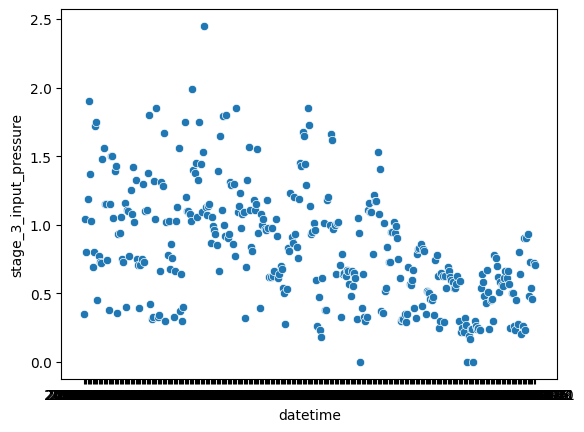

In [1254]:
#разберетесь с подписями графиков? мне в лом сейчас...
sns.scatterplot(x='datetime', y='stage_3_input_pressure', data=pivot_table)
# тут видно что один из замых опасных периодов - в начале. Есть большой выброс, а так же к концу данных тенденция на понижение

<Axes: xlabel='datetime', ylabel='stage_3_input_soft_water'>

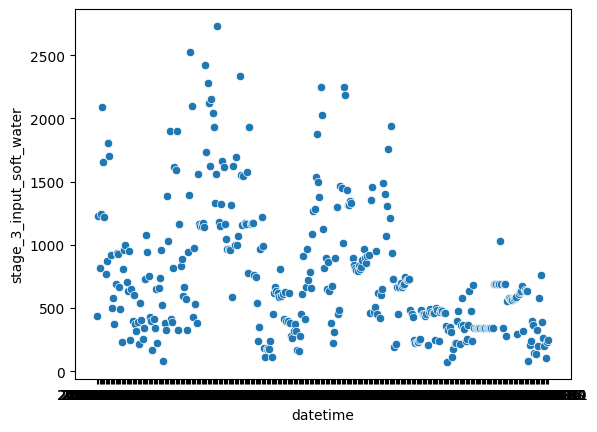

In [1255]:
sns.scatterplot(x='datetime', y='stage_3_input_soft_water', data=pivot_table)
# опасный период чуть дальше от начала

<Axes: xlabel='datetime', ylabel='stage_4_input_overheated_steam'>

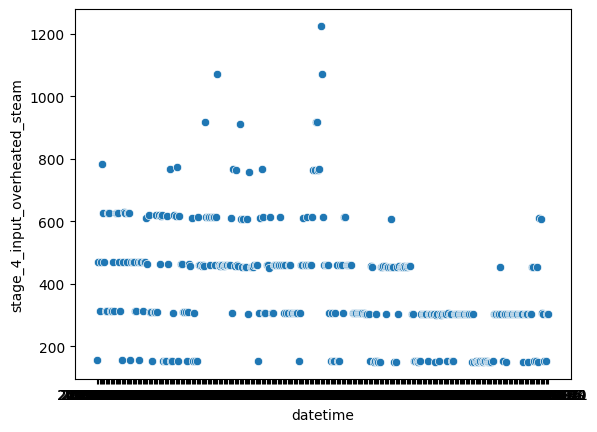

In [1256]:
sns.scatterplot(x='datetime', y='stage_4_input_overheated_steam', data=pivot_table)
#моя теория происходящего - они через какой то промежуток времени добавляют перегретый пар, потом сбрасывают цикл и начинают все сначала...влият ли это на danger_gas?


<Axes: xlabel='datetime', ylabel='stage_4_input_polymer'>

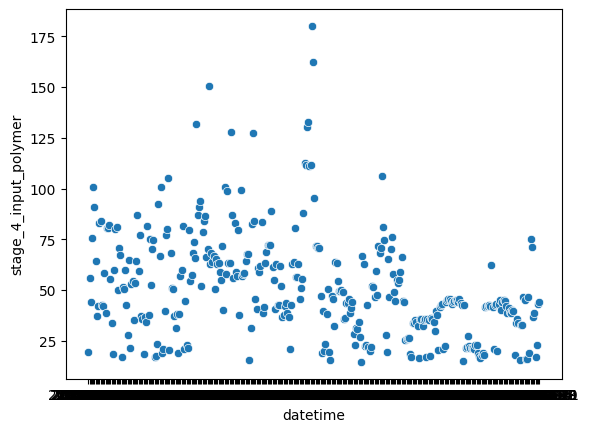

In [1257]:
sns.scatterplot(x='datetime', y='stage_4_input_polymer', data=pivot_table)
#возможно стоит построить со всеми данными, сдается мне тяжело смотреть на весь масштаб через игольное ушко

<Axes: xlabel='datetime', ylabel='stages_steam_sum'>

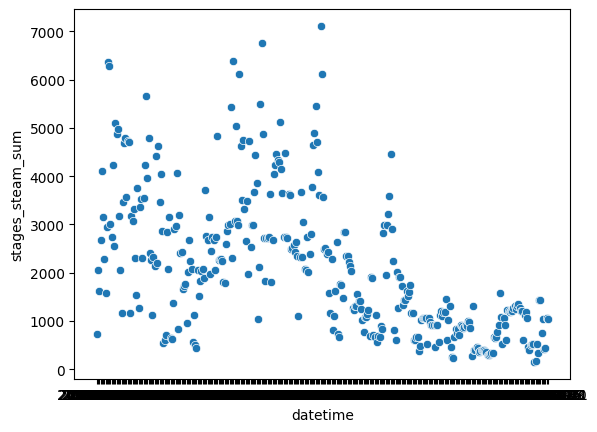

In [1258]:
sns.scatterplot(x='datetime', y='stages_steam_sum', data=pivot_table)
# мда... задумываюсь о том что реально стоить глянуть полный график 

<Axes: xlabel='datetime', ylabel='stages_water_sum'>

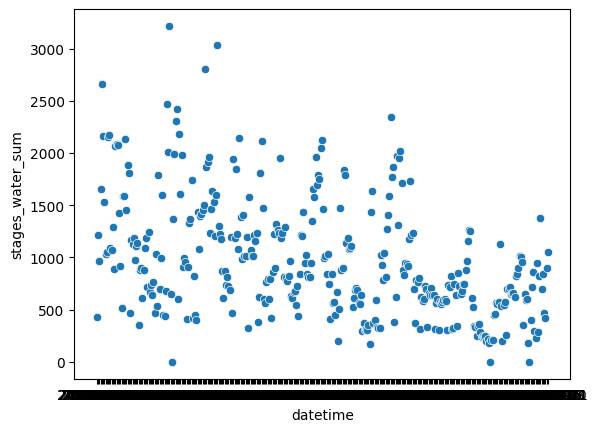

In [1259]:
sns.scatterplot(x='datetime', y='stages_water_sum', data=pivot_table)
#короче это все странно я не уверен что про это сказать, ну чуть после начала видно больше добавили газа, потом на снижение


#в целом видно, что данные снижаются со временем. ну т.е на всех графиках видно уменшьния всех параметров. Что с этим делать?

In [1260]:
#cледующая сводная таблица - таблица изменения категории опасности

df['datetime'] = df['datetime'].apply(lambda x: x[:-3])

for_table_df = df[['datetime', 'danger_gas_kat']]

for_table_df = for_table_df.groupby(['datetime'], as_index=False).value_counts()
pivot_table = for_table_df.pivot_table(index='datetime', aggfunc=mode)
pivot_table

,count,danger_gas_kat
datetime,,
2021-01,5,2
2021-02,50,2
2021-03,59,2
2021-04,33,2
2021-08,8,2
2021-09,3,2
2021-11,32,2
2021-12,54,3
2022-01,11,3


<Axes: xlabel='datetime', ylabel='danger_gas_kat'>

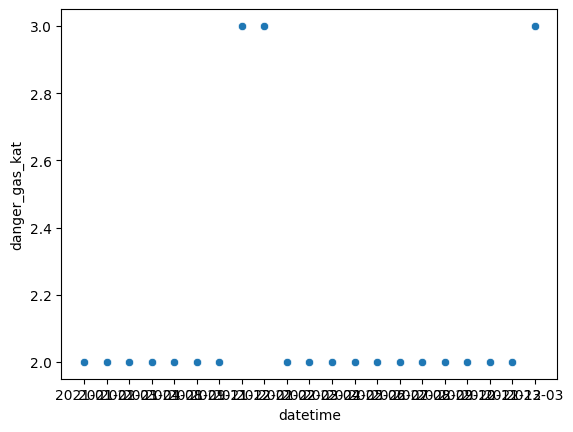

In [1261]:
sns.scatterplot(x='datetime', y='danger_gas_kat', data=pivot_table)


<Axes: xlabel='danger_gas_kat', ylabel='Density'>

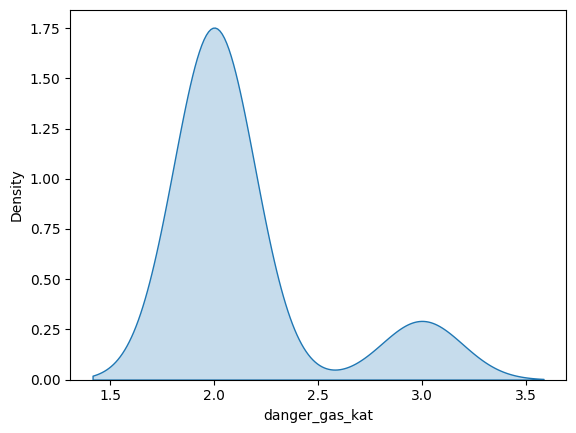

In [1262]:
sns.kdeplot(data=pivot_table, x='danger_gas_kat', fill=True)
#ну тут очевидно что 2 категории больше

In [ ]:
#вывести среднее значение каждого параметра 
# for i in range(1, 4):
#     curr_df = df[df['danger_gas_kat'] == i]
#     group
curr_df = df.copy()

curr_df.drop(['datetime', 'work_shift'], axis=1, inplace=True)

group = curr_df.groupby(['danger_gas_kat']).mean()
group


,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,stage_2_output_top_vacuum,...,stage_3_input_steam,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product
danger_gas_kat,,,,,,,,,,,,,,,,,,,,,
1,65.830000,80.640000,383.996000,78.536000,101.944000,56.360000,450.904000,266.380000,93.890000,58.212000,...,756.620000,109.586000,41.268000,153.314000,18.092000,4.612000,232.050000,0.036000,21.800000,43.484000
2,68.944000,87.820100,394.911503,79.060200,98.302202,56.647208,458.281405,262.251565,94.332712,59.409817,...,815.763509,109.372982,42.184465,153.348618,20.074738,5.218076,296.767615,0.119079,22.222434,44.234852
3,69.330631,86.504317,395.792212,78.733531,97.468785,56.722134,443.615625,263.886760,94.923574,56.928082,...,837.982150,109.972500,42.472492,153.236323,20.150375,5.581121,312.236355,0.181651,22.525171,42.330779


<Axes: >

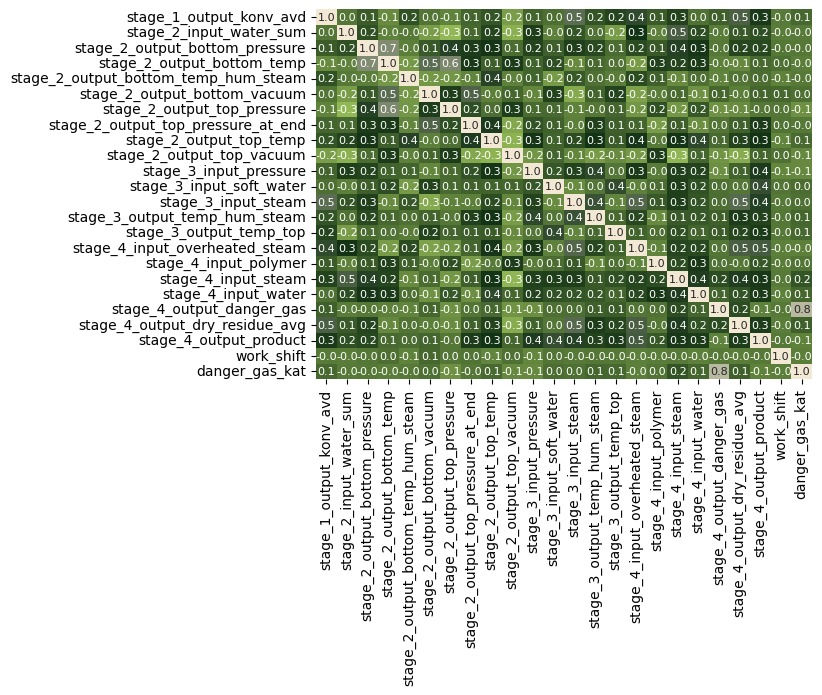

In [ ]:
spec_df = df.drop('datetime', axis=1)

correlation_matrix = spec_df.corr(method='spearman')
# по приколу хочу глянуть матрицу корреляций...можно за одно heatmap составить
#92B755
#133215
#F3E8D3
corporate_colors = ["#92B755", "#133215", "#F3E8D3"]  # Пример: красный, зеленый, голубой

# Создаем кастомную палитру
custom_gradient = LinearSegmentedColormap.from_list("CorporateGradient", corporate_colors)



sns.heatmap(correlation_matrix, cmap=custom_gradient, fmt='.1f', cbar=False, annot=True, annot_kws={"size": 8})

# стоит ли добавлять work_shift в матрицу корреляций???


#корреляция выбросов с итоговым продуктом/вредным газом
#проверить правильний ли метод используется корреляции для work_shift

#stage_4_output_danger_gas - матрица корелляций говорит, что нет сильных корелляций, только с danger_gas_kat, но это не им смылсла
#stage_4_output_dry_residue_avg - матрица корелляций показывает, что есть существенная зависимость с stage_1_output_konv_avd, stage_3_input_steam, stage_4_input_overheated_steam
#stage_4_output_product - матрица корелляций повествует, с stage_4_input_overheated_steam